In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import subprocess
import sys


class CovidDataset(object):

    def __init__(self, jhu_dataset=False):
        self.url = 'https://covidtracking.com/api/states/daily.csv'
        self.starting_caseload = 1
        self.l_localites = ['VA', 'NY', 'WA', 'CA', 'LA', 'FL', 'NJ', 'GA']
        self.d_remap = {'state': 'locality'}
        self.source_date_format = '%Y%m%d'
        self.jhu_dataset = jhu_dataset
        self.df = pd.DataFrame()

    @staticmethod
    def return_ordinal(num):
        suffixes = {1: 'st', 2: 'nd', 3: 'rd'}
        if 10 <= num % 100 <= 20:
            suffix = 'th'
        else:
            suffix = suffixes.get(num % 10, 'th')
        return str(num) + suffix

    def load(self, l_d_datasets=None):

        def _pull_jhu_dataset():
            df_day = pd.DataFrame()
            for col in self.df.columns[4:]:
                df_intraday = pd.DataFrame()
                print(pd.Timestamp(col))
                it = self.df.iterrows()
                for index, row in it:
                    day_row = {'date': pd.Timestamp(
                        col), 'locality': row['locality'],
                        'positive': row[col]}
                    df_intraday = df_intraday.append(day_row, ignore_index=True)
            self.df = df_day

        if l_d_datasets is not None:
            self.df = pd.DataFrame()
            for d_dataset in l_d_datasets:
                df = pd.read_csv(d_dataset['url'])
                if 'd_remap' in d_dataset.keys():
                    df.rename(columns=d_dataset['d_remap'], inplace=True)
                if 'l_assignments' in d_dataset.keys():
                    for assignment in d_dataset['l_assignments']:
                        df[assignment[0]] = assignment[1]
                if 'l_localities' in d_dataset.keys():
                    df = df[df['locality'].isin(d_dataset['l_localities'])]
                self.df = self.df.append(df, sort=False)
        else:
            df = pd.read_csv(self.url)
            df.rename(columns=self.d_remap, inplace=True)
            self.df = df
        if self.jhu_dataset:
            _pull_jhu_dataset()
        else:
            self.df['NewDate'] = pd.to_datetime(
                self.df['date'].copy(), format=self.source_date_format)

    def create_ft_figure(self, stat='positive', starting_caseload=100):

        def _modify_df(df, initial_caseload, plot_stat):
            pd.set_option("mode.chained_assignment", None)
            df['NewDate'] = pd.to_datetime(
                df['date'].copy(), format='%Y%m%d')
            start_date = df[(df[plot_stat]) >
                            initial_caseload]['NewDate'].min()
            df['date_zero'] = (df['NewDate'] -
                               start_date).astype('timedelta64[D]')
            pd.set_option("mode.chained_assignment", 'warn')
            return df

        ft_fig, ax = plt.subplots()
        df_grid = pd.DataFrame(index=np.arange(0, 100, 0.25))
        d_grids = {
            'daily': (1, (0, (5, 1))),
            '2 days': (2, (0, (5, 5))),
            '3 days': (3, (0, (5, 10))),
            'weekly': (7, (0, (1, 10)))}
        for grid in d_grids:
            df_grid[grid] = 2 ** (df_grid.index / d_grids[grid]
                                  [0]) * starting_caseload
            ax.semilogy(df_grid.index, df_grid[grid], label=grid,
                        color='darkgray', linestyle=d_grids[grid][1])
        x_max, y_max = 0, 0
        for locality in self.df['locality'].unique():
            df_plot = self.df[self.df['locality'] == locality]
            df_plot = _modify_df(df_plot, starting_caseload, stat)
            ax.semilogy(df_plot['date_zero'], df_plot[stat], label=locality)
            if df_plot[stat].max() > y_max:
                y_max = df_plot[stat].max()
            if df_plot['date_zero'].max() > x_max:
                x_max = df_plot['date_zero'].max()

        ax.set_ylim(top=y_max, bottom=starting_caseload)
        ax.set_xlim(left=0, right=x_max)
        ax.legend()
        str_xaxis_label = 'Days since {:s} {:s}'.format(
            self.return_ordinal(starting_caseload), stat)
        ax.set_xlabel(str_xaxis_label)
        str_yaxis_label = 'Total number of {:s}s'.format(stat)
        ax.set_ylabel(str_yaxis_label)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        return ft_fig


d_us = {'url': 'https://covidtracking.com/api/us/daily.csv',
        'd_remap': {'states': 'locality'},
        'source_date_format': '%Y%m%d',
        'l_assignments': [('locality', 'US')]
        }
d_state = {'url': 'https://covidtracking.com/api/states/daily.csv',
           'd_remap': {'state': 'locality'},
           'source_date_format': '%Y%m%d',
           'l_localities': ['VA', 'NY', 'WA', 'CA', 'LA', 'FL', 'NJ', 'GA'],
           }
d_jhu = {'url': 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/' +
         'master/csse_covid_19_data/csse_covid_19_time_series/' +
         'time_series_covid19_confirmed_global.csv',
         'd_remap': {'Country/Region': 'locality'},
         'l_localities': ['US', 'Italy', 'Iceland', 'China']
         }


def open_pdf(pdf_fname):
    open_cmd = 'open'
    if sys.platform == 'darwin':
        open_cmd = 'open'
    elif sys.platform == 'linux':
        open_cmd = 'xdg-open'
    elif sys.platform == 'win32':
        open_cmd = 'explorer'
    subprocess.run([open_cmd, pdf_fname])


def us_states_standard():
    us_states = CovidDataset()
    us_states.load([d_us, d_state])
    d_stats = {
        'cases': ('positive', 100),
        'deaths': ('death', 10)
    }
    for key in d_stats:
        fig = us_states.create_ft_figure(d_stats[key][0],
                                         d_stats[key][1])
        fname = 'covid_' + d_stats[key][0] + '.pdf'
        plt.savefig(fname)
        open_pdf(fname)





2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-25 00:00:00
2020-01-26 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-08 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-15 00:00:00
2020-02-16 00:00:00
2020-02-17 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00
2020-02-20 00:00:00
2020-02-21 00:00:00
2020-02-22 00:00:00
2020-02-23 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-26 00:00:00
2020-02-27 00:00:00
2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00


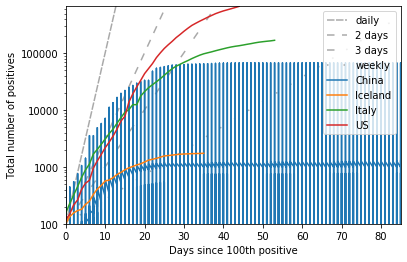

In [12]:
if __name__ == '__main__':

    countries = CovidDataset(jhu_dataset=True)
    countries.load([d_jhu])
    fig = countries.create_ft_figure('positive', 100)
    fname = 'covid_positive.pdf'
#     plt.savefig(fname)
#     open_pdf(fname)
    # us_states_standard()

In [13]:
countries.df

,date,locality,positive
0,2020-01-22,China,1.0
1,2020-01-22,China,14.0
2,2020-01-22,China,6.0
3,2020-01-22,China,1.0
4,2020-01-22,China,0.0
...,...,...,...
3091,2020-04-16,China,184.0
3092,2020-04-16,China,1268.0
3093,2020-04-16,Iceland,1739.0
3094,2020-04-16,Italy,168941.0


In [5]:
d_remap = {'Country/Region': 'locality'}
df.rename(columns=d_remap, inplace=True)

In [7]:
df['locality'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [8]:
l_localities = ['US', 'Italy', 'Iceland', 'China']

In [10]:
df[df['locality'].isin(l_localities)]

,Province/State,locality,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,991,991,991,991,991,991,991,991
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,587,588,588,588,589,589,589,589,590,593
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,579,579,579,579,579,579,579,579,579,579
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,351,351,351,351,351,352,352,353,353,353
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,...,139,139,139,139,139,139,139,139,139,139
54,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,1533,1536,1539,1544,1548,1552,1555,1564,1566,1571
55,Guangxi,China,23.8298,108.7881,2,5,23,23,36,46,...,254,254,254,254,254,254,254,254,254,254
56,Guizhou,China,26.8154,106.8748,1,3,3,4,5,7,...,146,146,146,146,146,146,146,146,146,146
57,Hainan,China,19.1959,109.7453,4,5,8,19,22,33,...,168,168,168,168,168,168,168,168,168,168
58,Hebei,China,39.5490,116.1306,1,1,2,8,13,18,...,327,327,327,327,327,327,327,327,327,328


In [15]:
df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
       '4/9/20', '4/10/20'

In [16]:
df.columns[4:]

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20',
       '4/13/20', '4/14/20', '4/15

In [39]:
df_day = pd.DataFrame()
for col in df.columns[4:]:
    it = df.iterrows()
    for index, row in it:
        day_row = {'date': pd.Timestamp(col), 'locality': row['Country/Region'], 'positive': row[col]}
        df_day = df_day.append(day_row, ignore_index=True)
        print(day_row)


{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Afghanistan', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Albania', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Algeria', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Andorra', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Angola', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Antigua and Barbuda', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Argentina', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Armenia', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Australia', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Australia', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Australia', 'positive': 0}
{'date': Timestamp('2020-01-22 00:00:00'), 'locality': 'Australia', 'positive': 0}
{'d

In [38]:
df_day

,date,locality,positive
0,2020-04-15,Afghanistan,784.0
1,2020-04-15,Albania,494.0
2,2020-04-15,Algeria,2160.0
3,2020-04-15,Andorra,673.0
4,2020-04-15,Angola,19.0
...,...,...,...
259,2020-04-15,France,1.0
260,2020-04-15,South Sudan,4.0
261,2020-04-15,Western Sahara,6.0
262,2020-04-15,Sao Tome and Principe,4.0


In [29]:
type(df_day)

pandas.core.frame.DataFrame

In [30]:
d_day

NameError: name 'd_day' is not defined

In [31]:
d_row

NameError: name 'd_row' is not defined

In [32]:
day_row

{'date': Timestamp('2020-04-15 00:00:00'), 'locality': 'Yemen', 'positive': 1}

In [34]:
df_day.append(day_row, ignore_index=True)

,date,locality,positive
0,2020-04-15,Yemen,1.0
